<a href="https://colab.research.google.com/github/lazy-wav/Data-Analysis/blob/main/gossip_on_poliDataDistil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving saved_model.zip to saved_model.zip


In [5]:
import zipfile

with zipfile.ZipFile("saved_model.zip", 'r') as zip_ref:
    zip_ref.extractall("saved_model")


In [6]:
from google.colab import files
uploaded = files.upload()


Saving politifact_fake.csv to politifact_fake.csv


In [7]:
uploaded = files.upload()

Saving politifact_real.csv to politifact_real.csv


In [8]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast
from datasets import Dataset
from transformers import DistilBertForSequenceClassification

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained('./saved_model')
model = DistilBertForSequenceClassification.from_pretrained('./saved_model')
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [10]:
true_data = pd.read_csv('politifact_real.csv')
fake_data = pd.read_csv('politifact_fake.csv')

true_data['label'] = 0
fake_data['label'] = 1

data = pd.concat([true_data, fake_data]).reset_index(drop=True)
texts = data['title'].fillna("").astype(str).tolist()
labels = data['label'].tolist()

# Tokenize texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=64, return_tensors='pt')

In [11]:
from datasets import load_metric

Accuracy: 0.6417

Classification Report:
              precision    recall  f1-score   support

        Real       0.67      0.86      0.75       797
        Fake       0.54      0.27      0.36       473

    accuracy                           0.64      1270
   macro avg       0.60      0.57      0.55      1270
weighted avg       0.62      0.64      0.61      1270

Confusion Matrix:
[[688 109]
 [346 127]]


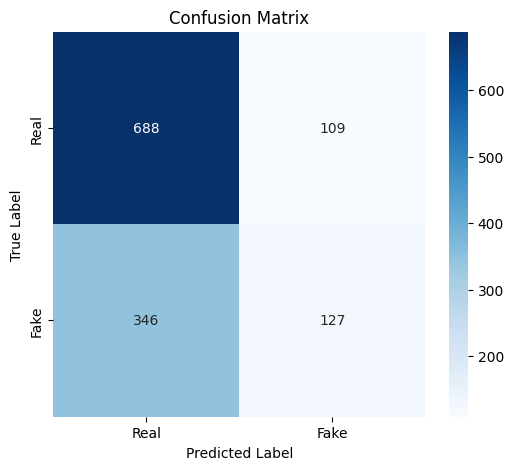

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# Step 6: Evaluation
acc = accuracy_score(labels, predictions)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(labels, predictions, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

# Optional: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
